<a href="https://colab.research.google.com/github/tanweer-mahdi/Multivariate-Time-Series-TMDB-5000/blob/main/movie_revenue_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import json 
import seaborn as sns
!pip3 install catboost
import catboost 
import sklearn
from collections import Counter
import matplotlib.pyplot as plt

     |████████████████████████████████| 69.2MB 56kB/s 


In [ ]:
df = pd.read_csv("tmdb_5000_movies.csv")

In [ ]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [ ]:
# removing data which are available after the release of the movie

In [ ]:
df.drop(["id", "popularity", "vote_average", "vote_count"], inplace=True, axis = 1)

In [ ]:
df.columns

Index(['budget', 'genres', 'homepage', 'keywords', 'original_language',
       'original_title', 'overview', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title'],
      dtype='object')

In [ ]:
ef = pd.read_csv("tmdb_5000_credits.csv")

In [ ]:
ef.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [ ]:
df.shape

(4803, 16)

In [ ]:
ef.shape

(4803, 4)

In [ ]:
ef.drop(["movie_id", "title"], inplace= True, axis = 1)

In [ ]:
dataset = pd.concat([df,ef], axis = 1)

In [ ]:
dataset.shape

(4803, 18)

In [ ]:
# exploring the dataset

In [ ]:
dataset.describe()

,budget,revenue,runtime
count,4.803000e+03,4.803000e+03,4801.000000
mean,2.904504e+07,8.226064e+07,106.875859
std,4.072239e+07,1.628571e+08,22.611935
min,0.000000e+00,0.000000e+00,0.000000
25%,7.900000e+05,0.000000e+00,94.000000
50%,1.500000e+07,1.917000e+07,103.000000
75%,4.000000e+07,9.291719e+07,118.000000
max,3.800000e+08,2.787965e+09,338.000000


In [ ]:
# getting rid of zero revenues

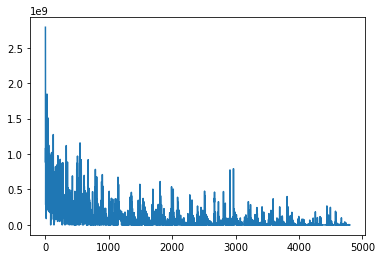

In [ ]:
dataset["revenue"].plot.line()
plt.show()

In [ ]:
# lots of movie has incorrect revenue data

In [ ]:
num_movies = []
for i in range(0,10000,100):
  num_movies.append(np.sum(dataset["revenue"] <= i))

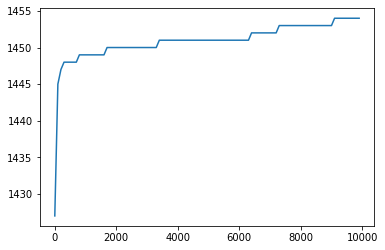

In [ ]:
sns.lineplot(x=[i for i in range(0,10000,100)], y = num_movies)
plt.show()

In [ ]:
rdataset = dataset.loc[dataset["revenue"] >= 4000]

In [ ]:
rdataset.describe()

,budget,revenue,runtime
count,3.352000e+03,3.352000e+03,3352.000000
mean,3.914353e+07,1.178693e+08,110.430191
std,4.425331e+07,1.838705e+08,21.086708
min,0.000000e+00,6.399000e+03,0.000000
25%,9.000000e+06,1.591894e+07,96.000000
50%,2.500000e+07,5.230340e+07,107.000000
75%,5.300000e+07,1.407987e+08,121.000000
max,3.800000e+08,2.787965e+09,338.000000


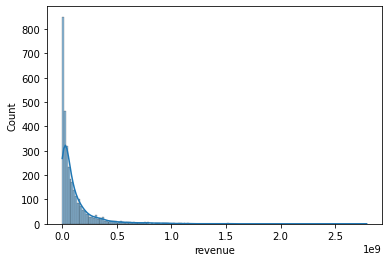

In [ ]:
sns.histplot(rdataset["revenue"], kde = True)
plt.show()

In [ ]:
# heavily skewed data. what about a log-transformation?

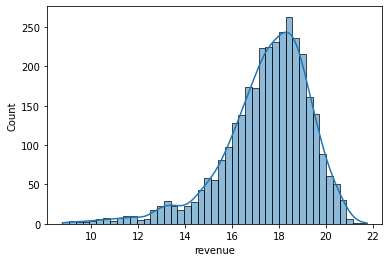

In [ ]:
sns.histplot(np.log(rdataset["revenue"]), kde=True)
plt.show()

In [ ]:
# quite nice transformation! Worth experimenting with!

In [ ]:
rdataset.describe()

,budget,revenue,runtime
count,3.352000e+03,3.352000e+03,3352.000000
mean,3.914353e+07,1.178693e+08,110.430191
std,4.425331e+07,1.838705e+08,21.086708
min,0.000000e+00,6.399000e+03,0.000000
25%,9.000000e+06,1.591894e+07,96.000000
50%,2.500000e+07,5.230340e+07,107.000000
75%,5.300000e+07,1.407987e+08,121.000000
max,3.800000e+08,2.787965e+09,338.000000


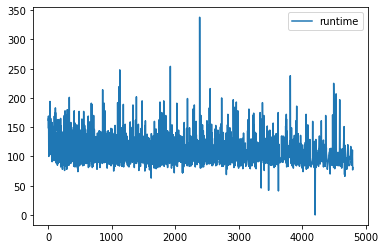

In [ ]:
rdataset[["runtime"]].plot.line()
plt.show()

In [ ]:
rdataset = rdataset.loc[rdataset["runtime"] != 0]

In [ ]:
rdataset.describe()

,budget,revenue,runtime
count,3.351000e+03,3.351000e+03,3351.000000
mean,3.915521e+07,1.179037e+08,110.463145
std,4.425475e+07,1.838872e+08,21.003349
min,0.000000e+00,6.399000e+03,41.000000
25%,9.000000e+06,1.596534e+07,96.000000
50%,2.500000e+07,5.230400e+07,107.000000
75%,5.300000e+07,1.408017e+08,121.000000
max,3.800000e+08,2.787965e+09,338.000000


In [ ]:
# budget depends on the production year. This missing value needs to be replaced carefully

In [ ]:
rdataset["release_year"] = pd.DatetimeIndex(rdataset["release_date"]).year

In [ ]:
rdataset.columns

Index(['budget', 'genres', 'homepage', 'keywords', 'original_language',
       'original_title', 'overview', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'cast', 'crew',
       'release_year'],
      dtype='object')

In [ ]:
rdataset[["release_year","release_date"]]

,release_year,release_date
0,2009,2009-12-10
1,2007,2007-05-19
2,2015,2015-10-26
3,2012,2012-07-16
4,2012,2012-03-07
...,...,...
4775,2002,2002-09-20
4788,1972,1972-03-12
4792,1997,1997-11-06
4796,2004,2004-10-08


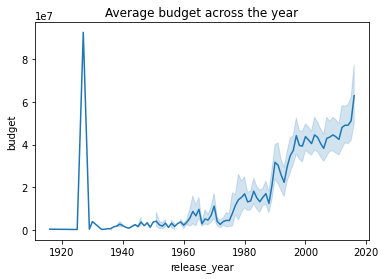

In [ ]:
%matplotlib inline
sns.lineplot(x=rdataset["release_year"], y=rdataset["budget"], data=rdataset, estimator='mean').set_title("Average budget across the year")
plt.show()

In [ ]:
# not a steady line but there exists a strong outlier in the budget

In [ ]:
# calculating mean budget every year 

In [ ]:
rdataset.columns

Index(['budget', 'genres', 'homepage', 'keywords', 'original_language',
       'original_title', 'overview', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'cast', 'crew',
       'release_year'],
      dtype='object')

In [ ]:
rdataset[["original_title","title"]]

,original_title,title
0,Avatar,Avatar
1,Pirates of the Caribbean: At World's End,Pirates of the Caribbean: At World's End
2,Spectre,Spectre
3,The Dark Knight Rises,The Dark Knight Rises
4,John Carter,John Carter
...,...,...
4775,Funny Ha Ha,Funny Ha Ha
4788,Pink Flamingos,Pink Flamingos
4792,キュア,Cure
4796,Primer,Primer


In [ ]:
rdataset.loc[rdataset["release_year"]<1940, ["budget", "original_title"]]

,budget,original_title
2638,92620000,Metropolis
3804,3950000,Hell's Angels
3813,4000000,Gone with the Wind
3986,2777000,The Wizard of Oz
4094,2000000,Alexander's Ragtime Band
4200,1644736,You Can't Take It With You
4216,1500000,Mr. Smith Goes to Washington
4238,1,Modern Times
4259,1488423,Snow White and the Seven Dwarfs
4312,1200000,The Charge of the Light Brigade


In [ ]:
rdataset.describe()

,budget,revenue,runtime,release_year
count,3.351000e+03,3.351000e+03,3351.000000,3351.000000
mean,3.915521e+07,1.179037e+08,110.463145,2001.865712
std,4.425475e+07,1.838872e+08,21.003349,13.095739
min,0.000000e+00,6.399000e+03,41.000000,1916.000000
25%,9.000000e+06,1.596534e+07,96.000000,1998.000000
50%,2.500000e+07,5.230400e+07,107.000000,2005.000000
75%,5.300000e+07,1.408017e+08,121.000000,2010.000000
max,3.800000e+08,2.787965e+09,338.000000,2016.000000


In [ ]:
# calculating average budget per year

In [ ]:
mean_budget = rdataset.groupby("release_year")["budget"].mean()

In [ ]:
rdataset["budget"] = rdataset["budget"].replace(0,np.NaN)

In [ ]:
rdataset["budget"] = rdataset["budget"].replace(1,np.NaN)

In [ ]:
mean_budget = rdataset.groupby("release_year")["budget"].mean()

In [ ]:
year_budget = {}
for i in mean_budget.index:
  year_budget[i] = mean_budget[i]

In [ ]:
year_budget

{1916: 385907.0,
 1925: 245000.0,
 1927: 92620000.0,
 1929: 379000.0,
 1930: 3950000.0,
 1933: 319500.0,
 1934: 325000.0,
 1935: 609000.0,
 1936: 1200000.0,
 1937: 1488423.0,
 1938: 1822368.0,
 1939: 2759000.0,
 1940: 2042000.0,
 1941: 1250000.0,
 1942: 868000.0,
 1944: 2494000.0,
 1945: 1636666.6666666667,
 1946: 3760000.0,
 1947: 2000000.0,
 1948: 3350000.0,
 1949: 1300000.0,
 1950: 3768785.0,
 1951: 4116666.6666666665,
 1952: 2423600.0,
 1953: 1802500.0,
 1954: 3227500.0,
 1955: 1200000.0,
 1956: 3166666.6666666665,
 1957: 1675000.0,
 1958: 3000000.0,
 1959: 3794616.0,
 1960: 2268982.6666666665,
 1961: 3580000.0,
 1962: 5525000.0,
 1963: 8712625.0,
 1964: 6607500.0,
 1965: 9700000.0,
 1966: 2900000.0,
 1967: 5166666.666666667,
 1968: 4668777.777777778,
 1969: 6805510.875,
 1970: 11210216.222222222,
 1971: 4018750.0,
 1972: 2642400.0,
 1973: 3957309.222222222,
 1974: 4514166.666666667,
 1975: 4450000.0,
 1976: 7842857.142857143,
 1977: 11628181.818181818,
 1978: 16000000.0,
 1979: 18

In [ ]:
temp = rdataset.copy()

In [ ]:
z = np.NaN
print(np.isnan(z))

True


In [ ]:
rdataset["budget"]

0       237000000.0
1       300000000.0
2       245000000.0
3       250000000.0
4       260000000.0
           ...     
4775            NaN
4788        12000.0
4792        20000.0
4796         7000.0
4798       220000.0
Name: budget, Length: 3351, dtype: float64

In [ ]:
def replacemean(x,y):
  if np.isnan(x):
    return year_budget[y]
  else:
    return x

In [ ]:
rdataset["nbudget"] = rdataset.apply(lambda x: replacemean(x.budget, x.release_year), axis=1)

In [ ]:
rdataset["nbudget"]

0       2.370000e+08
1       3.000000e+08
2       2.450000e+08
3       2.500000e+08
4       2.600000e+08
            ...     
4775    4.140496e+07
4788    1.200000e+04
4792    2.000000e+04
4796    7.000000e+03
4798    2.200000e+05
Name: nbudget, Length: 3351, dtype: float64

In [ ]:
rdataset[["budget","release_year","nbudget"]]

,budget,release_year,nbudget
0,237000000.0,2009,2.370000e+08
1,300000000.0,2007,3.000000e+08
2,245000000.0,2015,2.450000e+08
3,250000000.0,2012,2.500000e+08
4,260000000.0,2012,2.600000e+08
...,...,...,...
4775,NaN,2002,4.140496e+07
4788,12000.0,1972,1.200000e+04
4792,20000.0,1997,2.000000e+04
4796,7000.0,2004,7.000000e+03


In [ ]:
year_budget[2002]

41404963.04580153

In [ ]:
rdataset.describe()

,budget,revenue,runtime,release_year,nbudget
count,3.212000e+03,3.351000e+03,3351.000000,3351.000000,3.351000e+03
mean,4.084966e+07,1.179037e+08,110.463145,2001.865712,4.097032e+07
std,4.442999e+07,1.838872e+08,21.003349,13.095739,4.354859e+07
min,1.000000e+01,6.399000e+03,41.000000,1916.000000,1.000000e+01
25%,1.100000e+07,1.596534e+07,96.000000,1998.000000,1.175000e+07
50%,2.500000e+07,5.230400e+07,107.000000,2005.000000,2.800000e+07
75%,5.500000e+07,1.408017e+08,121.000000,2010.000000,5.327000e+07
max,3.800000e+08,2.787965e+09,338.000000,2016.000000,3.800000e+08


In [ ]:
rdataset.columns

Index(['budget', 'genres', 'homepage', 'keywords', 'original_language',
       'original_title', 'overview', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'cast', 'crew',
       'release_year', 'nbudget'],
      dtype='object')

In [ ]:
genres = []
for i in rdataset["genres"]:
  temp = json.loads(i)
  for j in temp:
    if j["name"] not in genres:
      genres.append(j["name"])

In [ ]:
genres

['Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Mystery',
 'History',
 'War',
 'Music',
 'Documentary',
 'Foreign']

In [ ]:
for i in genres:
  rdataset[i] = rdataset["genres"].apply(lambda x: 1 if i in x else 0)

In [ ]:
rdataset

,budget,genres,homepage,keywords,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,cast,crew,release_year,nbudget,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign
0,237000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,2.370000e+08,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,300000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007,3.000000e+08,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,245000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015,2.450000e+08,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,250000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012,2.500000e+08,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,260000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012,2.600000e+08,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,NaN,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,"[{""id"": 171993, ""name"": "

In [ ]:
def num_genre(x):
  num = 0
  for i in genres:
    if i in x: num += 1
  return num

In [ ]:
rdataset["num_genres"] = rdataset["genres"].apply(num_genre)

In [ ]:
rdataset.head(3)

,budget,genres,homepage,keywords,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,cast,crew,release_year,nbudget,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,num_genres
0,237000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,237000000.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,300000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007,300000000.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,245000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015,245000000.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


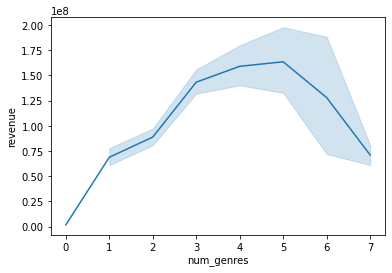

In [ ]:
# let me check if it is an useful feature
sns.lineplot(x="num_genres", y="revenue", data = rdataset)
plt.show()

In [ ]:
# finding the release months and see if it matters

In [ ]:
rdataset["release_month"] = pd.DatetimeIndex(rdataset["release_date"]).month

In [ ]:
rdataset["release_day"] = pd.DatetimeIndex(rdataset["release_date"]).weekday

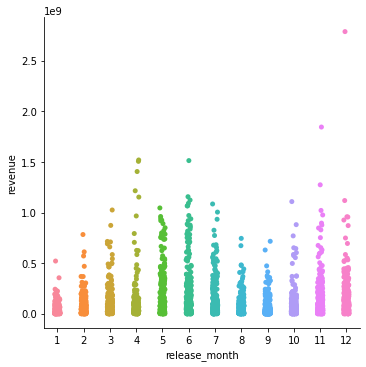

In [ ]:
sns.catplot(x="release_month", y = "revenue", data = rdataset)
plt.show()

In [ ]:
rdataset["has_homepage"] = 1

In [ ]:
rdataset.loc[rdataset["homepage"].isnull(),"has_homepage"] = 0

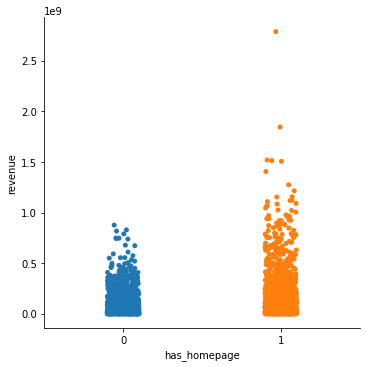

In [ ]:
sns.catplot(x="has_homepage", y="revenue", data=rdataset)
plt.show()

In [ ]:
rdataset["original_language"]

0       en
1       en
2       en
3       en
4       en
        ..
4775    en
4788    en
4792    ja
4796    en
4798    es
Name: original_language, Length: 3351, dtype: object

In [ ]:
rdataset.columns

Index(['budget', 'keywords', 'original_language', 'original_title', 'overview',
       'production_companies', 'production_countries', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'cast', 'crew',
       'release_year', 'nbudget', 'Action', 'Adventure', 'Fantasy',
       'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family',
       'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War',
       'Music', 'Documentary', 'Foreign', 'num_genres', 'release_month',
       'release_day', 'has_homepage'],
      dtype='object')

In [ ]:
rdataset.drop(["genres", "release_date", "homepage"], axis=1, inplace=True)

In [ ]:
rdataset.drop("keywords", inplace=True, axis=1)

In [ ]:
rdataset.drop("tagline", inplace=True, axis=1)

In [ ]:
rdataset.drop("original_title", inplace=True, axis=1)

In [ ]:
countries = []
for i in rdataset["production_countries"]:
  temp = json.loads(i)
  for j in temp:
    countries.append(j["name"])
    

In [ ]:
top_10 = Counter(countries).most_common(10)

In [ ]:
# I am not sure that I will be able to come up with good prediction using countries

In [ ]:
top_10

[('United States of America', 2998),
 ('United Kingdom', 453),
 ('Germany', 238),
 ('France', 206),
 ('Canada', 168),
 ('Australia', 81),
 ('Spain', 49),
 ('Italy', 48),
 ('Japan', 41),
 ('China', 39)]

In [ ]:
for i in top_10:
  country, _ = i
  rdataset[country] = rdataset["production_countries"].apply(lambda x: 1 if country in x else 0)

In [ ]:
def num_countries(x):
  temp = json.loads(x)
  return len(temp)

In [ ]:
rdataset["number_countries"] = rdataset["production_countries"].apply(num_countries)

In [ ]:
rdataset.head(2)

,budget,original_language,overview,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,cast,crew,release_year,nbudget,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,num_genres,release_month,release_day,has_homepage,United States of America,United Kingdom,Germany,France,Canada,Australia,Spain,Italy,Japan,China,number_countries
0,237000000.0,en,"In the 22nd century, a paraplegic Marine is di...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,237000000.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,12,3,1,1,1,0,0,0,0,0,0,0,0,2
1,300000000.0,en,"Captain Barbossa, long believed to be dead, ha...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007,300000000.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,5,1,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
# is there any correlation?

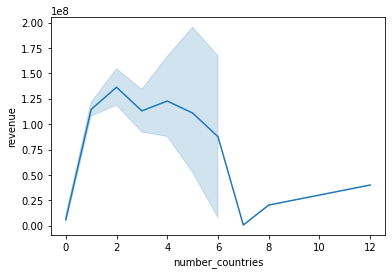

In [ ]:
sns.lineplot(x="number_countries", y= "revenue", data = rdataset)
plt.show()

In [ ]:
# selecting features for training
rdataset.columns

Index(['budget', 'original_language', 'overview', 'production_companies',
       'production_countries', 'revenue', 'runtime', 'spoken_languages',
       'status', 'title', 'cast', 'crew', 'release_year', 'nbudget', 'Action',
       'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller',
       'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror',
       'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign',
       'num_genres', 'release_month', 'release_day', 'has_homepage',
       'United States of America', 'United Kingdom', 'Germany', 'France',
       'Canada', 'Australia', 'Spain', 'Italy', 'Japan', 'China',
       'number_countries'],
      dtype='object')

In [ ]:
features = ["original_language", "runtime", "release_year", "nbudget", 'Action',
       'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller',
       'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror',
       'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign',
       'num_genres', 'release_month', 'release_day', 'has_homepage']

In [ ]:
features

['original_language',
 'runtime',
 'release_year',
 'nbudget',
 'Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Mystery',
 'History',
 'War',
 'Music',
 'Documentary',
 'Foreign',
 'num_genres',
 'release_month',
 'release_day',
 'has_homepage']

In [ ]:
from sklearn.model_selection import train_test_split
X_training, X_test, y_training, y_test = train_test_split(rdataset[features], rdataset["revenue"], test_size = 0.1, shuffle=True)

In [ ]:
categorical_features = ["original_language", "release_month", "release_day"]

In [ ]:
from catboost import Pool

In [ ]:
training_pool = Pool(X_training, label= y_training, cat_features=categorical_features)

In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=1000,
                        learning_rate=0.005,
                        depth=8,
                        l2_leaf_reg=None,
                        model_size_reg=None,
                        loss_function='RMSE')

In [ ]:
model.fit(training_pool)

0:	learn: 180780907.9200538	total: 12.5ms	remaining: 12.5s
1:	learn: 180371267.0823182	total: 23.2ms	remaining: 11.6s
2:	learn: 179983995.6452070	total: 33.7ms	remaining: 11.2s
3:	learn: 179568193.3582660	total: 59.7ms	remaining: 14.9s
4:	learn: 179168141.5398239	total: 84.2ms	remaining: 16.8s
5:	learn: 178736203.0603917	total: 95.1ms	remaining: 15.8s
6:	learn: 178359366.0006315	total: 106ms	remaining: 15s
7:	learn: 177977774.3728588	total: 117ms	remaining: 14.5s
8:	learn: 177599696.0244409	total: 127ms	remaining: 14s
9:	learn: 177207891.2392765	total: 134ms	remaining: 13.3s
10:	learn: 176818167.0349148	total: 146ms	remaining: 13.1s
11:	learn: 176443207.9052286	total: 157ms	remaining: 12.9s
12:	learn: 176122202.9892279	total: 160ms	remaining: 12.1s
13:	learn: 175767088.1606191	total: 163ms	remaining: 11.5s
14:	learn: 175412587.9627968	total: 173ms	remaining: 11.4s
15:	learn: 175099688.2919528	total: 184ms	remaining: 11.3s
16:	learn: 174756947.4658265	total: 195ms	remaining: 11.3s
17:	l

In [ ]:
ypred = model.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_test, ypred)

0.6813414159782727

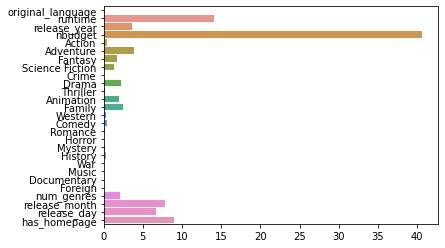

In [ ]:
sns.barplot(y=X_training.columns, x = model.get_feature_importance(), orient='h')
plt.show()

In [ ]:
rdataset["cast"][0]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [ ]:
all_cast = []
for i in rdataset["cast"]:
  temp = json.loads(i)
  for j in temp:
    all_cast.append(j["name"])

In [ ]:
len(all_cast)

86320

In [ ]:
all_cast[:3]

['Sam Worthington', 'Zoe Saldana', 'Sigourney Weaver']

In [ ]:
top_50 = Counter(all_cast).most_common(100)

In [ ]:
top_50

[('Samuel L. Jackson', 53),
 ('Robert De Niro', 49),
 ('Morgan Freeman', 45),
 ('Matt Damon', 45),
 ('Bruce Willis', 44),
 ('Johnny Depp', 38),
 ('Liam Neeson', 37),
 ('Owen Wilson', 37),
 ('Brad Pitt', 37),
 ('Willem Dafoe', 35),
 ('Nicolas Cage', 35),
 ('Steve Buscemi', 34),
 ('Stanley Tucci', 34),
 ('Tom Cruise', 33),
 ('Bill Murray', 33),
 ('Alec Baldwin', 32),
 ('Ben Stiller', 32),
 ('J.K. Simmons', 31),
 ('John Goodman', 31),
 ('Frank Welker', 31),
 ('Tom Hanks', 31),
 ('Arnold Schwarzenegger', 31),
 ('Harrison Ford', 31),
 ('Cameron Diaz', 31),
 ('George Clooney', 31),
 ('Will Ferrell', 31),
 ('Justin Long', 31),
 ('Bill Hader', 30),
 ('Jack Black', 30),
 ('Paul Giamatti', 30),
 ('Sylvester Stallone', 30),
 ('Ben Affleck', 29),
 ('Ben Kingsley', 29),
 ('Mark Wahlberg', 29),
 ('Woody Harrelson', 29),
 ('Seth Rogen', 29),
 ('Antonio Banderas', 29),
 ('Denzel Washington', 29),
 ('Laurence Fishburne', 28),
 ('Cate Blanchett', 28),
 ('Paul Rudd', 28),
 ('Christopher Walken', 28),
 ('

In [ ]:
for i in top_50:
  cast, _ = i
  rdataset[cast] = rdataset["cast"].apply(lambda x: 1 if cast in x else 0)

In [ ]:
rdataset.head(1)

,budget,original_language,overview,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,cast,crew,release_year,nbudget,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,num_genres,release_month,release_day,has_homepage,United States of America,United Kingdom,Germany,...,Ewan McGregor,Steve Zahn,Jim Carrey,Channing Tatum,Jude Law,Julianne Moore,Jason Bateman,John Travolta,Luis Guzmán,Robert Duvall,Christian Bale,Elizabeth Banks,Mark Ruffalo,James Marsden,Tom Wilkinson,Will Smith,Nicole Kidman,Hugh Jackman,Dwayne Johnson,Christopher Plummer,Viola Davis,John C. Reilly,Kristen Wiig,Anthony Hopkins,Octavia Spencer,Susan Sarandon,Forest Whitaker,Adam Sandler,Meryl Streep,Michael Caine,Jim Broadbent,Kevin Costner,Stephen Root,John Turturro,Jason Statham,John Hurt,Danny Glover,Terrence Howard,Eddie Murphy,Donald Sutherland
0,237000000.0,en,"In the 22nd century, a paraplegic Marine is di...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,237000000.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,12,3,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
bs_features = features.copy()

In [ ]:
for i in top_50:
  cast, _ = i
  if cast not in features:
    features.append(cast)

In [ ]:
features

['original_language',
 'runtime',
 'release_year',
 'nbudget',
 'Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Mystery',
 'History',
 'War',
 'Music',
 'Documentary',
 'Foreign',
 'num_genres',
 'release_month',
 'release_day',
 'has_homepage',
 'Samuel L. Jackson',
 'Robert De Niro',
 'Morgan Freeman',
 'Matt Damon',
 'Bruce Willis',
 'Johnny Depp',
 'Liam Neeson',
 'Owen Wilson',
 'Brad Pitt',
 'Willem Dafoe',
 'Nicolas Cage',
 'Steve Buscemi',
 'Stanley Tucci',
 'Tom Cruise',
 'Bill Murray',
 'Alec Baldwin',
 'Ben Stiller',
 'J.K. Simmons',
 'John Goodman',
 'Frank Welker',
 'Tom Hanks',
 'Arnold Schwarzenegger',
 'Harrison Ford',
 'Cameron Diaz',
 'George Clooney',
 'Will Ferrell',
 'Justin Long',
 'Bill Hader',
 'Jack Black',
 'Paul Giamatti',
 'Sylvester Stallone',
 'Ben Affleck',
 'Ben Kingsley',
 'Mark Wahlberg',
 'Woody Harrelson',
 'Seth Rogen',
 'Antonio Bandera

In [ ]:
bs_features

['original_language',
 'runtime',
 'release_year',
 'nbudget',
 'Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Mystery',
 'History',
 'War',
 'Music',
 'Documentary',
 'Foreign',
 'num_genres',
 'release_month',
 'release_day',
 'has_homepage',
 'Samuel L. Jackson',
 'Robert De Niro',
 'Morgan Freeman',
 'Matt Damon',
 'Bruce Willis',
 'Johnny Depp',
 'Liam Neeson',
 'Owen Wilson',
 'Brad Pitt',
 'Willem Dafoe',
 'Nicolas Cage',
 'Steve Buscemi',
 'Stanley Tucci',
 'Tom Cruise',
 'Bill Murray',
 'Alec Baldwin',
 'Ben Stiller',
 'J.K. Simmons',
 'John Goodman',
 'Frank Welker',
 'Tom Hanks',
 'Arnold Schwarzenegger',
 'Harrison Ford',
 'Cameron Diaz',
 'George Clooney',
 'Will Ferrell',
 'Justin Long',
 'Bill Hader',
 'Jack Black',
 'Paul Giamatti',
 'Sylvester Stallone',
 'Ben Affleck',
 'Ben Kingsley',
 'Mark Wahlberg',
 'Woody Harrelson',
 'Seth Rogen',
 'Antonio Bandera

In [ ]:
X_training, X_test, y_training, y_test = train_test_split(rdataset[features], rdataset["revenue"], test_size=0.1, shuffle = True)

In [ ]:
training_pool = Pool(data= X_training, label = y_training, cat_features=categorical_features)

CatBoostError: ignored

In [ ]:
model_2 =  CatBoostRegressor(iterations=1000,
                        learning_rate=0.005,
                        depth=8,
                        l2_leaf_reg=None,
                        model_size_reg=None,
                        loss_function='RMSE')

In [ ]:
model_2.fit(training_pool)

0:	learn: 183093164.4512689	total: 12.7ms	remaining: 12.6s
1:	learn: 182682039.8725871	total: 24.8ms	remaining: 12.4s
2:	learn: 182265148.3990888	total: 36.7ms	remaining: 12.2s
3:	learn: 181841714.2341246	total: 48.6ms	remaining: 12.1s
4:	learn: 181430950.2981442	total: 60.3ms	remaining: 12s
5:	learn: 181014226.1194547	total: 71.9ms	remaining: 11.9s
6:	learn: 180590974.1879906	total: 77.1ms	remaining: 10.9s
7:	learn: 180172497.5258161	total: 88.9ms	remaining: 11s
8:	learn: 179777935.7097771	total: 99.8ms	remaining: 11s
9:	learn: 179374459.7123055	total: 111ms	remaining: 11s
10:	learn: 178965074.1537254	total: 122ms	remaining: 11s
11:	learn: 178583461.8619186	total: 133ms	remaining: 11s
12:	learn: 178195187.6857811	total: 145ms	remaining: 11s
13:	learn: 177825017.1216618	total: 156ms	remaining: 11s
14:	learn: 177498773.5222575	total: 168ms	remaining: 11s
15:	learn: 177136530.1986581	total: 179ms	remaining: 11s
16:	learn: 176765744.0222221	total: 190ms	remaining: 11s
17:	learn: 176420618

In [ ]:
ypred = model_2.predict(X_test)

In [ ]:
r2_score(y_test, ypred)

0.574100240081393

In [ ]:
rdataset.columns

Index(['budget', 'original_language', 'overview', 'production_companies',
       'production_countries', 'revenue', 'runtime', 'spoken_languages',
       'status', 'title',
       ...
       'Jim Broadbent', 'Kevin Costner', 'Stephen Root', 'John Turturro',
       'Jason Statham', 'John Hurt', 'Danny Glover', 'Terrence Howard',
       'Eddie Murphy', 'Donald Sutherland'],
      dtype='object', length=148)